## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-2, l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if l1_ratio != 0 and l2_ratio == 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l1_ratio))(input_layer)
            elif l1_ratio != 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
            elif l1_ratio == 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1))(input_layer)
        else:
            if l1_ratio != 0 and l2_ratio == 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l1_ratio))(x)
            elif l1_ratio != 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
            elif l1_ratio == 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(x)
            else:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-6, 1e-12]
L2_EXP = [0.0, 1e-6, 1e-12]

In [7]:
L1_results = {}
L1_L2_results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for l2_r in L2_EXP:
    for l1_r in L1_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with L1 - %.12f, L2 - %12f" % (l1_r, l2_r))
        model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1_r, l2_ratio=l2_r)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        if l2_r == 0:
            exp_name_tag = "exp-l1-%s" % str(l1_r)
            L1_results[exp_name_tag] = {'train-loss': train_loss,
                                        'valid-loss': valid_loss,
                                        'train-acc': train_acc,
                                        'valid-acc': valid_acc}

        else:
            exp_name_tag = "exp-l1-%s, l2-%s" % (str(l1_r), str(l2_r))
            L1_L2_results[exp_name_tag] = {'train-loss': train_loss,
                                           'valid-loss': valid_loss,
                                           'train-acc': train_acc,
                                           'valid-acc': valid_acc}


W0718 19:28:31.888880 19776 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0718 19:28:31.888880 19776 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 19:28:31.899851 19776 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 19:28:31.900849 19776 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 19:28:31.901846 19

Experiment with L1 - 0.000001000000, L2 -     0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.0493 - acc: 0.2650 - val_loss: 1.8803 - val_acc: 0.3387
Epoch 2/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.8180 - acc: 0.3627 - val_loss: 1.7647 - val_acc: 0.3831
Epoch 3/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.7327 - acc: 0.3920 - val_loss: 1.6977 - val_acc: 0.4062
Epoch 4/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.6725 - acc: 0.4140 - val_loss: 1.6550 - val_acc: 0.4119
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.6251 - acc: 0.4308 - val_loss: 1.6106 - val_acc: 0.4327
Epoch 6/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.5860 - acc: 0.4438 - val_loss: 1.5864 - val_acc: 0.4419
Epoch 7/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.5494 - acc: 0.4572 - val_loss: 1.5532 - val_acc: 0.4547
Epoch 8/50
50000/50000 [=================

50000/50000 [==============================] - 2s 33us/step - loss: 1.8476 - acc: 0.3673 - val_loss: 1.8000 - val_acc: 0.3859
Epoch 3/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.7631 - acc: 0.3997 - val_loss: 1.7450 - val_acc: 0.4003
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.7050 - acc: 0.4187 - val_loss: 1.6855 - val_acc: 0.4233
Epoch 5/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6562 - acc: 0.4344 - val_loss: 1.6360 - val_acc: 0.4391
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6158 - acc: 0.4486 - val_loss: 1.6173 - val_acc: 0.4418
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5798 - acc: 0.4597 - val_loss: 1.5841 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5480 - acc: 0.4727 - val_loss: 1.5585 - val_acc: 0.4635
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 32us/step - loss: 1.7171 - acc: 0.3998 - val_loss: 1.6918 - val_acc: 0.4032
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6596 - acc: 0.4208 - val_loss: 1.6371 - val_acc: 0.4254
Epoch 5/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6135 - acc: 0.4377 - val_loss: 1.6009 - val_acc: 0.4317
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5735 - acc: 0.4502 - val_loss: 1.5812 - val_acc: 0.4436
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5409 - acc: 0.4610 - val_loss: 1.5519 - val_acc: 0.4499
Epoch 8/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5088 - acc: 0.4716 - val_loss: 1.5263 - val_acc: 0.4607
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4813 - acc: 0.4816 - val_loss: 1.5053 - val_acc: 0.4691
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 33us/step - loss: 1.6968 - acc: 0.4195 - val_loss: 1.6739 - val_acc: 0.4275
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6511 - acc: 0.4368 - val_loss: 1.6369 - val_acc: 0.4378
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6123 - acc: 0.4487 - val_loss: 1.6058 - val_acc: 0.4469
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5775 - acc: 0.4619 - val_loss: 1.5850 - val_acc: 0.4535
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5481 - acc: 0.4704 - val_loss: 1.5554 - val_acc: 0.4635
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5213 - acc: 0.4782 - val_loss: 1.5415 - val_acc: 0.4706
Epoch 10/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4962 - acc: 0.4889 - val_loss: 1.5268 - val_acc: 0.4695
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 33us/step - loss: 1.6150 - acc: 0.4332 - val_loss: 1.6020 - val_acc: 0.4352
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5766 - acc: 0.4460 - val_loss: 1.5720 - val_acc: 0.4510
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5443 - acc: 0.4577 - val_loss: 1.5541 - val_acc: 0.4512
Epoch 8/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.5157 - acc: 0.4676 - val_loss: 1.5221 - val_acc: 0.4649
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4887 - acc: 0.4770 - val_loss: 1.5015 - val_acc: 0.4704
Epoch 10/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4658 - acc: 0.4839 - val_loss: 1.4892 - val_acc: 0.4745
Epoch 11/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4415 - acc: 0.4929 - val_loss: 1.4799 - val_acc: 0.4773
Epoch 12/50
50000/50000 [=========================

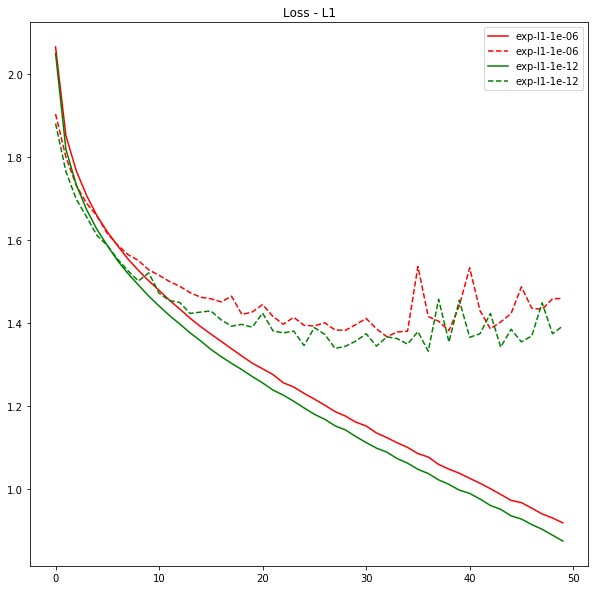

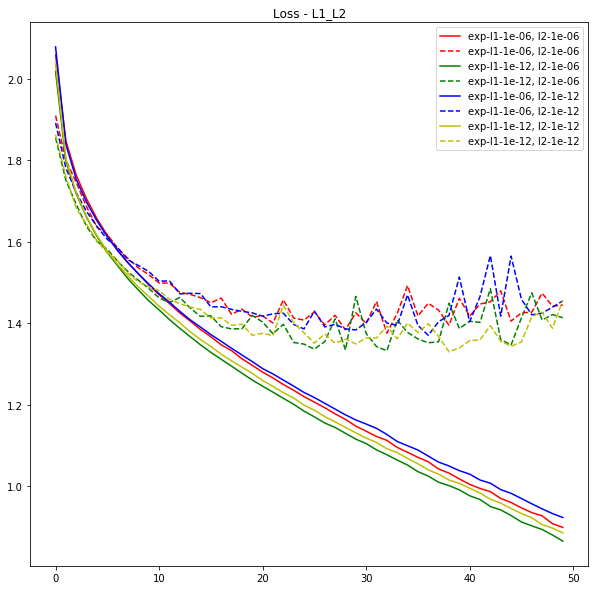

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "goldenrod", "c", "orchid", "palevioletred", "saddlebrown", "lime"]

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_results.keys()):
    plt.plot(range(len(L1_results[cond]['train-loss'])), L1_results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_results[cond]['valid-loss'])), L1_results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
plt.title("Loss - L1")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_L2_results.keys()):
    plt.plot(range(len(L1_L2_results[cond]['train-loss'])), L1_L2_results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_L2_results[cond]['valid-loss'])), L1_L2_results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
plt.title("Loss - L1_L2")
plt.legend()
plt.show()

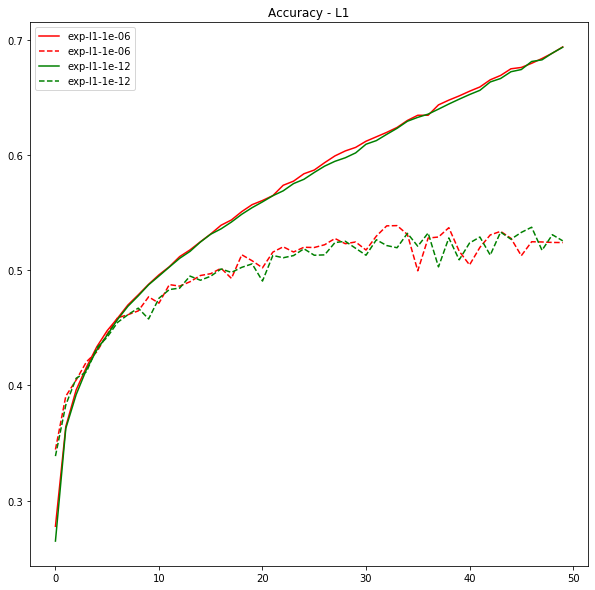

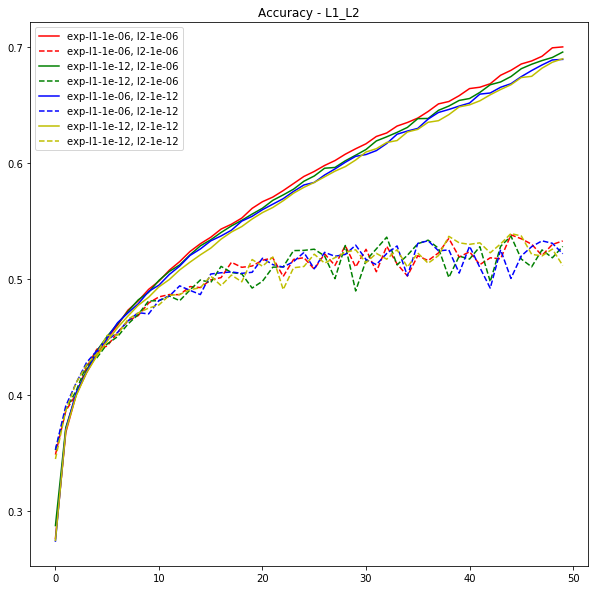

In [9]:
plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_results.keys()):
    plt.plot(range(len(L1_results[cond]["train-acc"])), L1_results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_results[cond]["valid-acc"])), L1_results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
plt.title("Accuracy - L1")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_L2_results.keys()):
    plt.plot(range(len(L1_L2_results[cond]["train-acc"])), L1_L2_results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_L2_results[cond]["valid-acc"])), L1_L2_results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
plt.title("Accuracy - L1_L2")
plt.legend()
plt.show()

## 結果討論

以valid data來看，L1及L1_L2的Accuracy都差不多落在0.5左右
